In [243]:
import lpips
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms.functional import resize

In [2]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt

In [3]:
gt_path = Path('benchmark/result/test1_bicubic/full_result/GT/frame_001.PNG')
sample_path = Path('benchmark/result/test1_bicubic/full_result/Real-ESRGAN/frame_001.PNG')

In [4]:
def read_image(path):
    image = cv2.imread(str(path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

In [5]:
gt = read_image(gt_path)
sample = read_image(sample_path)

In [6]:
%matplotlib widget
plt.imshow(gt)

In [7]:
metric = lpips.LPIPS()
metric.eval()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /Users/e.lyapustin/Projects/sr/restoration-metric/.venv/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


LPIPS(
  (scaling_layer): ScalingLayer()
  (net): alexnet(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
    )
    (slice2): Sequential(
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
    )
    (slice3): Sequential(
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
    )
    (slice4): Sequential(
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
    )
    (slice5): Sequential(
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
  )
  (lin0): NetLinLayer(
    (model): Sequential(
      (0): D

In [18]:
def process_image(image: np.array):
    image = image.astype(np.float64) / 255 * 2 - 1
    image = image.transpose(2, 0, 1)
    return torch.from_numpy(image).float()

def image_to_pil(image: torch.tensor):
    return to_pil_image(image / 2 + 0.5)

In [9]:
metric(process_image(gt), process_image(sample))

tensor([[[[0.2100]]]], grad_fn=<AddBackward0>)

In [10]:
metric(process_image(gt), process_image(gt))

tensor([[[[0.]]]], grad_fn=<AddBackward0>)

In [11]:
gt_torch = process_image(gt)
sample_torch = process_image(sample)

In [69]:
side = 1920
for i in [32, 64, 128, 256, 512]:
    pad = get_padding(side, i, i)
    print(f'{side} /', i, '\t\t=', side / i, '\t pad =', pad)
    print(f'({side} + {pad}) /', i, '\t=', (side + pad) / i)

1920 / 32 		= 60.0 	 pad = 0
(1920 + 0) / 32 	= 60.0
1920 / 64 		= 30.0 	 pad = 0
(1920 + 0) / 64 	= 30.0
1920 / 128 		= 15.0 	 pad = 0
(1920 + 0) / 128 	= 15.0
1920 / 256 		= 7.5 	 pad = 128
(1920 + 128) / 256 	= 8.0
1920 / 512 		= 3.75 	 pad = 128
(1920 + 128) / 512 	= 4.0


In [63]:
1.0 // 2

0.0

In [212]:
def get_padding(side, patch_size, stride):
    subd = side - patch_size
    return int(np.ceil(subd / stride)) * stride - subd

def smart_unfold(image, patch_size, stride=None):
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    if stride is None:
        stride = patch_size

        
    *_, h, w = image.shape
    padding = (
        get_padding(h, patch_size, stride) // 2,
        get_padding(w, patch_size, stride) // 2,
    )
    image = F.unfold(image, patch_size, stride=stride, padding=padding)
    image = image.view(1, 3, patch_size, patch_size, -1)

    return image

def get_fold_divisor(image: torch.tensor, patch_size, stride, padding):
    if len(image.shape) == 3:
        image = image.unsqueeze(0)

    # Remove redundant samples and channels
    image = image[:1, :1]

    input_ones = torch.ones(image.shape, dtype=image.dtype)
    divisor = F.fold(F.unfold(input_ones, patch_size, stride=stride, padding=padding), image.shape[-2:], patch_size, stride=stride, padding=padding)

    return divisor

def probs_fold(probs, output_size, patch_size, stride):
    probs_repeated = probs[:, None, None].repeat(1, patch_size, patch_size, 1).view(probs.shape[0], -1, probs.shape[1])

    h, w = output_size
    padding = (
        get_padding(h, patch_size, stride) // 2,
        get_padding(w, patch_size, stride) // 2,
    )
    probs_folded = F.fold(probs_repeated, output_size, patch_size, stride=stride, padding=padding)
    
    return probs_folded / get_fold_divisor(probs_folded, patch_size, stride, padding)

def patch_lpips(gt, sample, patch_size, stride=None):
    if stride is None:
        stride = patch_size
    
    gt_blocks = smart_unfold(gt, patch_size, stride)
    sample_blocks = smart_unfold(sample, patch_size, stride)

    gt_blocks = torch.movedim(gt_blocks, -1, 1)
    sample_blocks = torch.movedim(sample_blocks, -1, 1)

    batch_size, n_blocks, *shape = gt_blocks.shape

    gt_blocks = gt_blocks.view(batch_size * n_blocks, *shape)
    sample_blocks = sample_blocks.view(batch_size * n_blocks, *shape)

    with torch.no_grad():
        probs = metric(gt_blocks, sample_blocks)

    new_h = int(np.ceil((gt.shape[-2] - patch_size) / stride)) + 1
    new_w = int(np.ceil((gt.shape[-1] - patch_size) / stride)) + 1
    probs = probs.view(batch_size, n_blocks)# .squeeze(0)
    
    # probs = probs.view(batch_size, new_h, new_w)# .squeeze(0)
    # probs = resize(probs, gt.shape[-2:])

    probs = probs_fold(probs, gt.shape[-2:], patch_size, stride=stride)
    probs = probs[:, 0].squeeze(0)

    return probs

In [181]:
fig, axes = plt.subplots(figsize=(7, 5))

axes.imshow(to_pil_image(sample_torch / 2 + 0.5))
res = patch_lpips(gt_torch, sample_torch, 32, 32)
bar = axes.imshow(res, alpha=0.9)

plt.colorbar(bar)
plt.tight_layout()

In [182]:
fig, axes = plt.subplots(figsize=(7, 5))

axes.imshow(to_pil_image(sample_torch / 2 + 0.5))
res = patch_lpips(gt_torch, sample_torch, 64, 64)
bar = axes.imshow(res, interpolation='bilinear', alpha=0.9)

plt.colorbar(bar)
plt.tight_layout()

In [183]:
fig, axes = plt.subplots(figsize=(7, 5))

axes.imshow(to_pil_image(sample_torch / 2 + 0.5))
res = patch_lpips(gt_torch, sample_torch, 256, 256)
bar = axes.imshow(res, interpolation='bilinear', alpha=0.9)

plt.colorbar(bar)
plt.tight_layout()

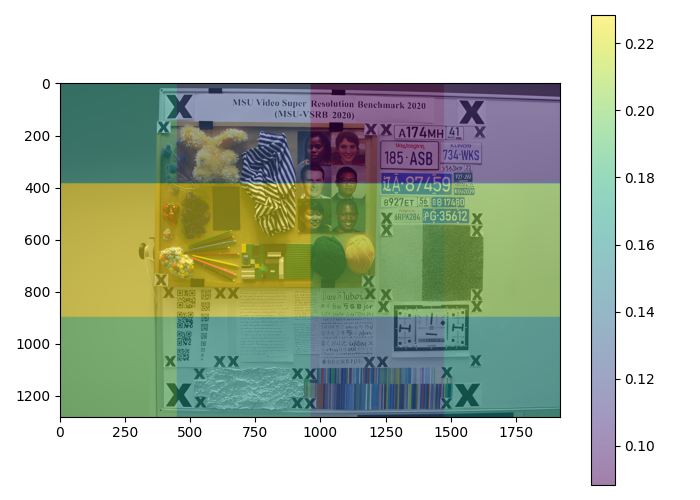

In [184]:
fig, axes = plt.subplots(figsize=(7, 5))


axes.imshow(to_pil_image(sample_torch / 2 + 0.5))
res = patch_lpips(gt_torch, sample_torch, 512, 512)
bar = axes.imshow(res, interpolation='bilinear', alpha=0.5)

plt.colorbar(bar)
plt.tight_layout()

In [187]:
results = []
for patch_size in [32, 64, 128, 256, 512]:
    res = patch_lpips(gt_torch, sample_torch, patch_size, patch_size)
    results.append(res)

res = torch.stack(results).mean(dim=0)

In [238]:
from matplotlib.widgets import Button, Slider


class HeatmapState:
    def __init__(self, gt, sample, heatmap):
        self.gt = gt
        self.sample = sample
        self.heatmap = heatmap
        
        self.show_sample = True
        self.fig, self.axes = plt.subplots(figsize=(7, 5))
        
        self.plot()
        plt.colorbar(self.bar)
        plt.tight_layout()

    def plot_image(self, image, **kwargs):
        return self.axes.imshow(to_pil_image(image / 2 + 0.5), **kwargs)
    
    def plot_heatmap(self):
        self.bar = self.axes.imshow(self.heatmap, interpolation='bilinear', alpha=0.9, cmap='Reds')
    
    def plot(self):
        self.gt_bar = self.plot_image(self.gt, alpha=0)
        self.sample_bar = self.plot_image(self.sample)
        self.plot_heatmap()
        
    def update(self, event):
        self.bar.set(alpha=event)
        plt.draw()
    
    def toggle(self, event):
        self.show_sample = not self.show_sample
        if self.show_sample:
            self.gt_bar.set(alpha=0)
            self.sample_bar.set(alpha=1)
        else:
            self.gt_bar.set(alpha=1)
            self.sample_bar.set(alpha=0)
        plt.draw()

state = HeatmapState(gt_torch, sample_torch, res)
                         
axfreq = plt.axes([0.1, 0.05, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Alpha',
    valmin=0.0,
    valmax=1.0,
    valinit=0.75,
)
freq_slider.on_changed(state.update)

axbut = plt.axes([0.6, 0.1, 0.2, 0.05])
button = Button(
    ax=axbut,
    label='Toggle',
)
button.on_clicked(state.toggle)

state.axes.set_title('LPIPS heatmap')
plt.show()

In [232]:
from functools import partial

import cv2
import numpy as np


def make_slice(img, left, right, axis):
    sl = [slice(None)] * img.ndim
    sl[axis] = slice(left, right)

    return img[tuple(sl)]


def shift1d(img, gt, shift=1, axis=0):
    if shift > 0:
        x1, x2 = shift, img.shape[axis]
        x3, x4 = 0, -shift  # gt
    elif shift == 0:
        x1, x2, x3, x4 = 0, img.shape[axis], 0, img.shape[axis]
    else:
        x1, x2 = 0, shift
        x3, x4 = -shift, img.shape[axis]

    img = make_slice(img, x1, x2, axis=axis)
    gt = make_slice(gt, x3, x4, axis=axis)

    return img, gt


def shift2d(img, gt, a=1, b=1):
    img, gt = shift1d(img, gt, a, axis=0)
    img, gt = shift1d(img, gt, b, axis=1)

    return img, gt


class ERQA:
    def __init__(self, shift_compensation=True, penalize_wider_edges=None, global_compensation=True, version='1.0'):
        """
        shift_compensation - if one-pixel shifts of edges are compensated
        """
        # Set global defaults
        self.global_compensation = global_compensation
        self.shift_compensation = shift_compensation

        # Set version defaults
        if version == '1.0':
            self.penalize_wider_edges = False
        elif version == '1.1':
            self.penalize_wider_edges = True
        else:
            raise ValueError('There is no version {} for ERQA'.format(version))

        # Override version defaults
        if penalize_wider_edges is not None:
            self.penalize_wider_edges = penalize_wider_edges

        # Set detector
        self.edge_detector = partial(cv2.Canny, threshold1=100, threshold2=200)

    def __call__(self, img, gt, return_maps=False):
        assert gt.shape == img.shape
        assert gt.shape[2] == 3, 'Compared images should be in BGR format'

        if self.global_compensation:
            img, gt = self._global_compensation(img, gt)

        edge = self.edge_detector(img) // 255
        gt_edge = self.edge_detector(gt) // 255

        true_positive, false_negative = self.match_edges(edge, gt_edge)

        f1 = self.f1_matches(edge, true_positive, false_negative)

        false_positive = edge - true_positive
        if return_maps:
            return f1, true_positive, false_positive, false_negative
        else:
            return f1

    def _global_compensation(self, img, gt_img, window_range=3, metric='mse'):
        window = range(-window_range, window_range + 1)

        if metric == 'mse':
            def metric(x, y):
                return np.mean((x.astype(float) - y.astype(float)) ** 2)
        else:
            raise ValueError('Unsupported metric "{}" for global compensation'.format(metric))

        shifts = {}
        for i in window:
            for j in window:
                shifted_img, cropped_gt_img = shift2d(img, gt_img, i, j)

                metric_value = metric(shifted_img, cropped_gt_img)
                shifts[(i, j)] = metric_value

        (i, j), _ = min(shifts.items(), key=lambda x: x[1])

        return shift2d(img, gt_img, i, j)

    def match_edges(self, edge, gt_edge):
        assert gt_edge.shape == edge.shape

        true_positive = np.zeros_like(edge)
        false_negative = gt_edge.copy()

        # Count true positive
        if self.shift_compensation:
            window_range = 1
        else:
            window_range = 0

        window = sorted(range(-window_range, window_range + 1), key=abs)  # Place zero at first place

        for i in window:
            for j in window:
                gt_ = np.roll(false_negative, i, axis=0)
                gt_ = np.roll(gt_, j, axis=1)

                ad = edge * gt_ * np.logical_not(true_positive)

                np.logical_or(true_positive, ad, out=true_positive)
                if self.penalize_wider_edges:
                    # Unmark already used edges
                    ad = np.roll(ad, -j, axis=1)
                    ad = np.roll(ad, -i, axis=0)
                    np.logical_and(false_negative, np.logical_not(ad), out=false_negative)

        if not self.penalize_wider_edges:
            false_negative = gt_edge * np.logical_not(true_positive)

        assert not np.logical_and(true_positive, false_negative).any()

        return true_positive, false_negative

    def f1_matches(self, edge, true_positive, false_negative):
        tp = np.sum(true_positive)
        fp = np.sum(edge) - tp
        fn = np.sum(false_negative)

        if tp + fn == 0:
            f1 = 1
        elif tp == 0:
            f1 = 0
        elif tp + fp == 0:
            f1 = 0
        else:
            prec = tp / (tp + fp)
            recall = tp / (tp + fn)

            f1 = 2 * prec * recall / (prec + recall)

        return f1

    def generate_visualization(self, edge, true_positive, false_negative):
        """
        Form f1 data into RGB visualization

        - False Negative - blue
        - False Positive - red
        - False Negative - white
        - False Negative - black

        Args:
            edge (np.array): edge mask of image
            true_positive (np.array): true positive mask from `match_edges`
            false_negative (np.array): false negative mask from `match_edges`
        """
        false_positive = edge - true_positive

        # Using BGR as in OpenCV
        blue = np.array([1, 0, 0])
        red = np.array([0, 0, 1])
        white = np.array([1, 1, 1])

        return false_negative[..., None] * blue[None, None] \
               + false_positive[..., None] * red[None, None] \
               + true_positive[..., None] * white[None, None]


In [233]:
erqa = ERQA()

In [200]:
score, *maps = erqa(sample[..., ::-1], gt[..., ::-1], return_maps=True)

In [204]:
tp, fp, fn = maps

In [207]:
plt.close('all')

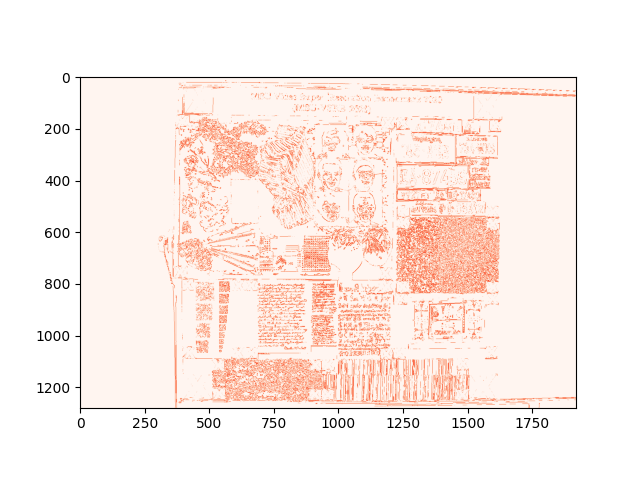

In [209]:
erqa_heatmap = np.logical_or(fp, fn)

plt.imshow(erqa_heatmap, cmap='Reds')
plt.show()

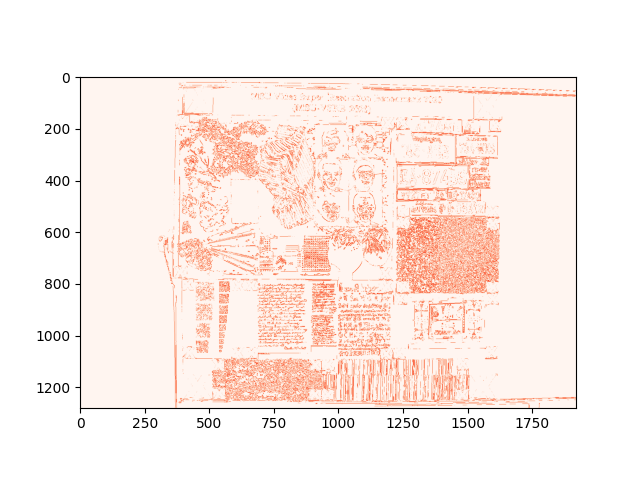

In [209]:
patch_size = 32
for y in range(

In [234]:
def patch_erqa(gt, sample, patch_size, stride=None):
    if stride is None:
        stride = patch_size
    
    gt_blocks = smart_unfold(gt, patch_size, stride)
    sample_blocks = smart_unfold(sample, patch_size, stride)

    gt_blocks = torch.movedim(gt_blocks, -1, 1)
    sample_blocks = torch.movedim(sample_blocks, -1, 1)

    batch_size, n_blocks, *shape = gt_blocks.shape

    gt_blocks = gt_blocks.view(batch_size * n_blocks, *shape)
    sample_blocks = sample_blocks.view(batch_size * n_blocks, *shape)

    half255 = 255 / 2
    probs = [
        erqa(
            np.moveaxis(sample_block.numpy() * half255 + half255, -3, -1).astype(np.uint8),
            np.moveaxis(gt_block.numpy() * half255 + half255, -3, -1).astype(np.uint8)
        ) for sample_block, gt_block in zip(sample_blocks, gt_blocks)
    ]
    probs = torch.tensor(probs).float()

    new_h = int(np.ceil((gt.shape[-2] - patch_size) / stride)) + 1
    new_w = int(np.ceil((gt.shape[-1] - patch_size) / stride)) + 1
    probs = probs.view(batch_size, n_blocks)# .squeeze(0)
    
    # probs = probs.view(batch_size, new_h, new_w)# .squeeze(0)
    # probs = resize(probs, gt.shape[-2:])

    probs = probs_fold(probs, gt.shape[-2:], patch_size, stride=stride)
    probs = probs[:, 0].squeeze(0)

    return probs

In [235]:
erqa_res = patch_erqa(gt_torch, sample_torch, 16, 16)

In [236]:
erqa_res

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [299]:
from matplotlib.widgets import Button, Slider


class HeatmapState:
    def __init__(self, gt, sample, heatmap, ax=None):
        self.gt = gt
        self.sample = sample
        self.heatmap = heatmap
        
        self.show_sample = True
        if ax is None:
            self.fig, self.axes = plt.subplots(figsize=(7, 5))
        else:
            self.fig, self.axes = None, ax
        
        self.plot()
                                         
        axfreq = plt.axes([0.1, 0.03, 0.65, 0.03])
        self.freq_slider = Slider(
            ax=axfreq,
            label='Alpha',
            valmin=0.0,
            valmax=1.0,
            valinit=0.75,
        )
        self.freq_slider.on_changed(self.update)

        axbut = plt.axes([0.83, 0.03, 0.15, 0.05])
        self.button = Button(
            ax=axbut,
            label='Toggle',
        )
        self.button.on_clicked(self.toggle)
        
        plt.colorbar(self.bar, ax=self.axes)

    def plot_image(self, image, **kwargs):
        return self.axes.imshow(to_pil_image(image / 2 + 0.5), **kwargs)
    
    def plot_heatmap(self):
        self.bar = self.axes.imshow(self.heatmap, interpolation='bilinear', alpha=0.9, cmap='Reds')
    
    def plot(self):
        self.gt_bar = self.plot_image(self.gt, alpha=0)
        self.sample_bar = self.plot_image(self.sample)
        self.plot_heatmap()
        
    def update(self, event):
        self.bar.set(alpha=event)
        plt.draw()
    
    def toggle(self, event):
        print('HUH')
        self.show_sample = not self.show_sample
        if self.show_sample:
            self.gt_bar.set(alpha=0)
            self.sample_bar.set(alpha=1)
        else:
            self.gt_bar.set(alpha=1)
            self.sample_bar.set(alpha=0)
        plt.draw()

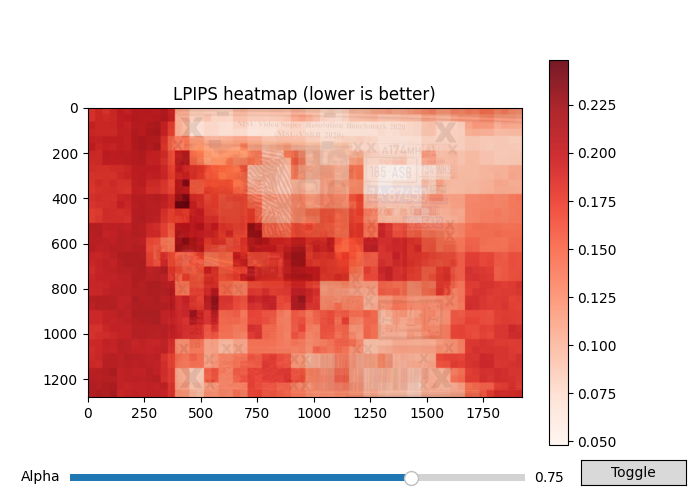

In [303]:
lpips_state = HeatmapState(gt_torch, sample_torch, res)

lpips_state.axes.set_title('LPIPS heatmap (lower is better)')

# plt.tight_layout()
plt.show()

In [304]:
erqa_state = HeatmapState(gt_torch, sample_torch, 1 - erqa_res)

erqa_state.axes.set_title('ERQA heatmap (lower is better)')

# plt.tight_layout()
plt.show()

In [273]:
plt.close('all')